In [1]:
%%capture
# Running the previous notebooks
%run TSP.ipynb
%run TSPextended.ipynb
%run LocalSearch.ipynb
%run EvolutionaryAlgorithmTSP.ipynb

#Importing their classes
tsp = TSP()
tsp_ext = TSPext()
localsearch = LocalSearch()

Importing the relevant packages.
We require the following:

In [2]:
import pandas as pd
import numpy as np
from numpy import random as npr
import matplotlib.pyplot as plt
import copy
import warnings
import time

In [3]:
#Importing the distance dataframe for testing
columns = [i for i in range(1,26)]
distance_dataframe_test = pd.read_csv('distance_dataframes/dist_dataframe_normal_1_25_wo:9.csv',names = columns)
distance_dataframe_test = distance_dataframe_test.iloc[1:]

In [4]:
#Test
distance_dataframe_test.head()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,0.00,0.14,0.32,0.47,0.30,0.54,0.15,0.44,0.37,0.37,...,0.09,0.46,0.17,0.51,0.53,0.49,0.23,0.10,0.06,0.56
2,0.14,0.00,0.41,0.61,0.17,0.58,0.11,0.50,0.35,0.49,...,0.12,0.46,0.31,0.49,0.41,0.52,0.36,0.23,0.13,0.42
3,0.32,0.41,0.00,0.34,0.48,0.82,0.32,0.70,0.69,0.18,...,0.41,0.27,0.32,0.37,0.81,0.78,0.40,0.24,0.29,0.73
4,0.47,0.61,0.34,0.00,0.74,0.76,0.57,0.63,0.75,0.16,...,0.54,0.61,0.34,0.70,1.00,0.75,0.36,0.38,0.49,1.01
5,0.30,0.17,0.48,0.74,0.00,0.73,0.17,0.67,0.47,0.61,...,0.29,0.43,0.47,0.42,0.37,0.66,0.53,0.37,0.26,0.26


Let us generate a random candidate solution for the regular TSP. 

In [5]:
#Generating a random route using the RandomCandidate function from EATSP.ipynb
tmp_random_route = RandomCandidate(25)
tmp_random_route

array([ 7, 21,  3, 25,  2, 13,  1,  5,  8, 22, 18,  4, 23, 11, 10, 12, 20,
       19, 17,  6,  9, 15, 16, 24, 14])

For this report, we need to consider the time taken for the truck or drone to travel between each pair of nodes.

We can define a function which takes the distance dataframe, and returns two different dataframes, one for the time involved with the truck traversing between each pair of nodes and likewise one for the drone. It will calculate each dataframe by multiplying the original distance dataframe by a scalar factor $(1/speed)$ to determine the time.

In [6]:
def multiplydistancedataframe(distance_dataframe, truck_multiplier, drone_multiplier):
    truck_costs = distance_dataframe * truck_multiplier
    drone_costs = distance_dataframe * drone_multiplier
    drone_costs = drone_costs.round(2)
    
    return(truck_costs, drone_costs)

In [7]:
#Test with assumption that speed of truck = 1 and speed of drone = 1.33
test_truck_time_dataframe, test_drone_time_dataframe = multiplydistancedataframe(distance_dataframe_test, 1, 0.75)

In [8]:
test_truck_time_dataframe.head()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,0.00,0.14,0.32,0.47,0.30,0.54,0.15,0.44,0.37,0.37,...,0.09,0.46,0.17,0.51,0.53,0.49,0.23,0.10,0.06,0.56
2,0.14,0.00,0.41,0.61,0.17,0.58,0.11,0.50,0.35,0.49,...,0.12,0.46,0.31,0.49,0.41,0.52,0.36,0.23,0.13,0.42
3,0.32,0.41,0.00,0.34,0.48,0.82,0.32,0.70,0.69,0.18,...,0.41,0.27,0.32,0.37,0.81,0.78,0.40,0.24,0.29,0.73
4,0.47,0.61,0.34,0.00,0.74,0.76,0.57,0.63,0.75,0.16,...,0.54,0.61,0.34,0.70,1.00,0.75,0.36,0.38,0.49,1.01
5,0.30,0.17,0.48,0.74,0.00,0.73,0.17,0.67,0.47,0.61,...,0.29,0.43,0.47,0.42,0.37,0.66,0.53,0.37,0.26,0.26


In [9]:
test_drone_time_dataframe.head()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,0.00,0.11,0.24,0.35,0.22,0.40,0.11,0.33,0.28,0.28,...,0.07,0.34,0.13,0.38,0.40,0.37,0.17,0.08,0.04,0.42
2,0.11,0.00,0.31,0.46,0.13,0.43,0.08,0.38,0.26,0.37,...,0.09,0.34,0.23,0.37,0.31,0.39,0.27,0.17,0.10,0.32
3,0.24,0.31,0.00,0.26,0.36,0.62,0.24,0.52,0.52,0.14,...,0.31,0.20,0.24,0.28,0.61,0.58,0.30,0.18,0.22,0.55
4,0.35,0.46,0.26,0.00,0.55,0.57,0.43,0.47,0.56,0.12,...,0.40,0.46,0.26,0.52,0.75,0.56,0.27,0.29,0.37,0.76
5,0.22,0.13,0.36,0.55,0.00,0.55,0.13,0.50,0.35,0.46,...,0.22,0.32,0.35,0.32,0.28,0.50,0.40,0.28,0.20,0.20


We can now create a function that will return the dataframes which contain the travel time between each pair of nodes for both vehicles provided a distance matrix.

In [10]:
def createDistanceDataframes_25cities(dataframe_path, truck_multiplier, drone_multiplier):
    #Importing the distance dataframe
    columns = [i for i in range(1,26)]
    distance_dataframe = pd.read_csv(dataframe_path,names = columns)
    distance_dataframe = distance_dataframe.iloc[1:]
    
    #Creating the individual dataframes
    truck_time_dataframe, drone_time_dataframe = multiplydistancedataframe(distance_dataframe, truck_multiplier, drone_multiplier)

    return(distance_dataframe, truck_time_dataframe, drone_time_dataframe)

In order to specify which nodes are visited by the truck and which are visited by the drone, we need to label each node with a binary digit, $1$ or $0$. A label of $1$ will indicate that the node is visited by a truck, while a label of $0$ will indicate the node is visited by the drone.

In [11]:
def node_allocation_to_truck_drone(number_of_cities):
    
    #Using numpy.random to generate a uniform random np array with 1s and 0s
    allocated_nodes = npr.randint(2, size =number_of_cities)
    return(allocated_nodes)

In [12]:
#Test
tmp_allocation = node_allocation_to_truck_drone(25)
tmp_allocation

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1])

Although we have generated an array which contains labels (of $1$ or $0$) for each node, we need a function that will "fix" the array so that it satisfies the conditions specified in the $FSTSP$ model. These include the condition that a drone must return to the truck after visiting a node, which implies that there cannot be 2 or more consecutive $0$ in the allocation array.

In [13]:
def ensure_validity_of_allocation_simple(allocation_array):
    rng = npr.default_rng()
    
    #List comprehension for checking if there are two zeros in a row, in which case the first one will be flipped to a 1
    allocations = [1 if (allocation_array[index] == 0 and allocation_array[index+1] == 0) else (allocation) for index, allocation in enumerate(allocation_array[:-1])]
    last_allocation = [x for x in allocation_array[-1:]]
    allocations = allocations + last_allocation
    allocation_array = allocations
    
    #We need to introduce some stochaticity in the generation of valid route arrays to increase the search space
    #This loop randomly determines if there are three 1s in a row, in which case it flips the middle one to a 0.
    if rng.random() < 0.5:
        for i in range(1, len(allocation_array)-1):
            #one counter will determine how many 1s the loop comes across for each index i
            one_counter = 0
            if (allocation_array[i]==1):
                one_counter = one_counter + 1
                #If the next allocation is a 1 increment one counter 
                if ((one_counter==1) and (allocation_array[i+1]==1)):
                    one_counter = one_counter+ 1
                    # If the previous allocation is a 1 flip the allocation value to a 0
                    if (one_counter==2 and (allocation_array[i-1]==1)):
                        allocation_array[i] = 0
    else:
        pass
    
    allocation_array = np.array(allocation_array)
    
    return allocation_array

In [14]:
#Test
tmp_allocation_fixed = ensure_validity_of_allocation_simple(tmp_allocation)
tmp_allocation_fixed

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1])

The $FSTSP$ also considers the flight endurance, $e$, of a drone, with the requirement that $t_1 + t_2 \leq e$, where $t_1$ is the time taken for the drone to fly to the node from the truck and $t_2$ is the return time to the truck.

The function $drone\_endurance\_check$ determines if a drone is able to complete a sortie to a depot node, with the assumption that it then visits the truck after completing the sortie. For a given route, it will return an array with true or false binary values, with the value stating whether or not it is legal for the drone to travel to the node at this index from the previous node.

In [15]:
def drone_endurance_check(drone_endurance, route, drone_distance_matrix):
    travel_validity = []
    
    #Determining if the cost between traversing the current node and the next node if legal for the drone
    #i.e. if the flight range of the drone in time is less than the travel time between the nodes
    for i in range(len(route)-1):
        cost_between_nodes = drone_distance_matrix.loc[route[i], route[i+1]] 
        if cost_between_nodes < drone_endurance:   
            travel_validity.append(1)
        else:
            travel_validity.append(0)        
    
    #Considering the cost of traversing between from the penultimate node to the last node
    cost_between_nodes = drone_distance_matrix.loc[route[i-2], route[i-1]]     
    if cost_between_nodes < drone_endurance:   
        travel_validity.append(1)
    else:
        travel_validity.append(0)
    
    travel_validity = np.array(travel_validity)
    
    return(travel_validity)

In [16]:
tmp_random_route

array([ 7, 21,  3, 25,  2, 13,  1,  5,  8, 22, 18,  4, 23, 11, 10, 12, 20,
       19, 17,  6,  9, 15, 16, 24, 14])

In [17]:
#Test
tmp_endurance_array = drone_endurance_check(0.5, tmp_random_route, distance_dataframe_test)
tmp_endurance_array

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1])

In [18]:
tmp_allocation_fixed

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1])

We now need to determine if any 0 nodes in our allocation array are illegal due to the flight range of the drone. The function $pairwise\_array$ takes an allocation array and an endurance array with binary 1/0 values for drone travel, and changes a $1$ to $0$ if a drone cannot travel to that node.

In [19]:
def endurance_check_allocation_array(endurance_array, allocation_array):
    #If drone endurance is false but the allocation array has specified that the drone travels to that node, we need to flip it to a 1.
    
    updated_allocation_array = np.where(endurance_array <1, 1, allocation_array)
    
    '''
    for i in range(len(endurance_array)):
        if endurance_array[i] :
            
            
    
    for i in range(len(compare)):
        if endurance_array[i] == 0:
            if allocation_array[i] == 0:
                allocation[i] = 0
        else:
            pass
    '''    
    return updated_allocation_array

In [20]:
endurance_check_allocation_array(tmp_endurance_array, tmp_allocation_fixed)

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1])

We can now update the $ensure\_validity\_of\_route$ function to include the drone endurance check.

In [21]:
def ensure_validity_of_allocation(allocation, route, drone_endurance, drone_distance_matrix):
    
    #Checking the allocation array to see if the drone can travel between its allocated nodes
    endurance_array = drone_endurance_check(drone_endurance, route, drone_distance_matrix)
    allocation_endurance_checked = endurance_check_allocation_array(endurance_array, allocation)
    
    #Ensuring there are no two 0s in a row
    allocation_zeros_checked = ensure_validity_of_allocation_simple(allocation_endurance_checked)
   
    #allocation_zeros_checked = np.array([allocation_zeros_checked])
    
    return allocation_zeros_checked

In [22]:
tmp_allocation_two = ensure_validity_of_allocation(tmp_allocation, tmp_random_route, 1, distance_dataframe_test)
tmp_allocation_two

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1])

Creating a random population

In [23]:
#Generating a population of solutions using RandomPopulation from EATSP.ipynb
tmp_population = RandomPopulation(100, 25)
tmp_population

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,10,21,1,17,24,23,20,14,22,16,...,15,3,13,19,5,8,4,7,18,11
2,15,10,16,2,3,19,18,5,25,24,...,22,8,13,21,11,12,7,23,17,1
3,20,5,24,7,18,6,10,22,4,21,...,15,14,3,13,12,23,2,1,9,8
4,15,14,1,6,21,2,12,13,25,22,...,16,19,4,24,5,18,11,23,10,20
5,21,11,19,3,24,18,1,7,23,12,...,16,10,15,17,14,9,20,22,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,25,14,8,5,23,10,7,12,20,3,...,4,15,11,6,24,18,19,1,2,9
97,7,17,4,5,1,15,12,9,25,14,...,6,11,2,18,3,21,20,19,10,22
98,5,12,4,23,6,15,19,10,3,2,...,16,9,21,20,24,11,7,22,13,8
99,2,22,12,14,17,1,8,7,4,9,...,16,15,20,13,23,18,19,3,11,5


For a given population, we need to generate an array where row $i$ corresponds to the node allocation array for individual $i$ in the population. 

In [24]:
def RandomNodeAllocation(drone_endurance, population_size, number_of_cities, population_dataframe, drone_distance_matrix):
    
    #Initializing the database to hold the random candidates
    initialization = CandidatePopulation(population_size, number_of_cities)
    
    #Creating 
    for j in range(1, population_size+1):
        
        random_allocation = node_allocation_to_truck_drone(number_of_cities)
        
        route = population_dataframe.loc[j]
        
        route = np.array(route)
        
        random_allocation = ensure_validity_of_allocation(random_allocation, route, drone_endurance, drone_distance_matrix)
        
        initialization.loc[j] = random_allocation
    
    return(initialization)

In [25]:
#Test
tmp_random_allocation_population = RandomNodeAllocation(1, 100, 25, tmp_population, distance_dataframe_test)
tmp_random_allocation_population

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,1,0,1,1,0,1,0,1,1,0,...,0,1,1,0,1,0,1,1,0,1
2,1,1,0,1,0,1,0,1,1,0,...,1,0,1,0,1,0,1,0,1,0
3,1,0,1,0,1,0,1,1,0,1,...,1,0,1,0,1,0,1,0,1,1
4,0,1,1,0,1,0,1,0,1,1,...,1,0,1,0,1,1,0,1,0,1
5,1,0,1,0,1,0,1,0,1,0,...,0,1,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,0,1,0,1,1,0,1,1,1,...,1,1,1,0,1,0,1,1,0,1
97,1,0,1,0,1,0,1,0,1,1,...,1,0,1,0,1,0,1,0,1,0
98,1,0,1,0,1,0,1,0,1,0,...,0,1,0,1,0,1,0,1,1,0
99,1,0,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0,1,1,0,1


Alternativley, we can apply a scaling factor to the $EuclideanDistanceCalculator$ function from $TSPextended$. The functions $truckdistancefunction$ and $dronedistancefunction$ applies a scaling factor to the distance function in order to account for the difference in cost between the two. 

In [26]:
def truckdistancefunction(city_coordinates, i, j, truck_scaling_factor = 1):
    truck_distance = truck_scaling_factor * tsp_ext.EuclideanDistanceCalculator(i, j, city_coordinates)
    return truck_distance

def dronedistancefunction(city_coordinates, i, j, drone_scaling_factor = 0.8):
    drone_distance = drone_scaling_factor * tsp_ext.EuclideanDistanceCalculator(i,j, city_coordinates)
    return drone_distance

In [27]:
#Importing the synthetic dataset
synthetic_data_w = pd.read_csv('synthetic_data_w.csv', index_col='Unnamed: 0')

In [28]:
synthetic_data_w.head()

,x,y,d
1,41.915,-8.658,0.488
2,-82.733,-56.033,0.699
3,-50.526,-72.741,0.874
4,92.750,79.535,0.697
5,70.477,-41.388,0.387


In [29]:
#Test
truckdistancefunction(synthetic_data_w, 1, 5)

43.44008222828313

We can now define a function which will take a route, and node allocation array and return two seperate arrays, one which will contain the cost for each node pair the truck traverses, and the other will contain the costs for each node pair the drone traverses.

In [30]:
def FSTSPCostofRoute(route, node_allocation, truck_distance_dataframe, drone_distance_dataframe):
    
    #Initializing 
    truck_route_cost = []
    drone_route_cost = []
    
    max_index = len(route) - 1
    
    #Determining the cost of traversing the route with the truck and node
    for index, node in enumerate(route[:-1]):
        current_node = route[index]
        next_node = route[index+1]
        
        current_allocation = node_allocation[index]
        next_allocation = node_allocation[index+1]
        
        #Determining if the current node is the starting point of a UAV sortie
        if (current_allocation==1) and (next_allocation==0):    
                #Taking the cost of the drone between nodes i, i+1
                drone_cost_between_nodes = drone_distance_dataframe.loc[current_node, next_node]
                drone_route_cost.append(drone_cost_between_nodes)
                
                if index < (max_index - 2):
                        next_next_node = route[index+2]
                        #Taking cost of truck between (i,i+2)
                        truck_cost_between_adjacent_nodes = truck_distance_dataframe.loc[current_node, next_next_node]
                        truck_route_cost.append(truck_cost_between_adjacent_nodes)
        
        elif (current_allocation==1) and (next_allocation==1):
                cost_between_nodes = truck_distance_dataframe.loc[current_node, next_node]
                truck_route_cost.append(cost_between_nodes)
                
        elif (current_allocation==0) and (next_allocation==1):
                cost_between_nodes = drone_distance_dataframe.loc[current_node, next_node]
                drone_route_cost.append(cost_between_nodes)
        
        else:
                pass
        
    #Here, we are assuming that the drone cannot return to the home depot directly from the last node            
    #Determing the cost to go from last node to home depot
    
    #Checking the condition if the drone visits the last node
    if (node_allocation[max_index] == 0):
            #Return to truck at previous node
            cost_of_returning_to_truck_from_last_node = drone_distance_dataframe.loc[max_index, max_index-1]
            drone_route_cost.append(cost_of_returning_to_truck_from_last_node)
            #We need the cost of the truck returning from the second to last node to the home depot
            cost_of_truck_returning_home_depot = truck_distance_dataframe.loc[max_index, 1]
            truck_route_cost.append(cost_of_truck_returning_home_depot)

    elif node_allocation[max_index] == 1:
            #We need the cost of the truck returning from the last node to the home depot
            cost_of_truck_returning_home_depot = truck_distance_dataframe.loc[max_index, 1]
            truck_route_cost.append(cost_of_truck_returning_home_depot)
   
            
    return(truck_route_cost, drone_route_cost)

In [31]:
#truck_route_cost, drone_route_cost = FSTSPCostofRoute(tmp_random_route, tmp_allocation_two, test_truck_time_dataframe, test_drone_time_dataframe)

In [32]:
#truck_route_cost

In [33]:
#drone_route_cost

The function $TotalCost$ will sum the individual costs in the $truck\_route\_cost$ and $drone\_route\_cost$ arrays.

In [34]:
def TotalCost(truck_route_costs, drone_route_costs):
    #
    drone_total_cost = sum(truck_route_costs)
    truck_total_cost = sum(drone_route_costs)
    total_cost = drone_total_cost + truck_total_cost
    total_cost = total_cost * -1
    return total_cost

In [35]:
#Test
#TotalCost(truck_route_cost, drone_route_cost)

We can now define the class $RandomInitializationFSTSP$, which will initialise a population for the FSTSP using random search.

In [36]:
class RandomInitializationFSTSP:
    def __init__(self, size_of_population, number_of_cities, distance_matrix, truck_distance_matrix, drone_distance_matrix, drone_endurance, inverse_truck_speed, inverse_drone_speed):
        self.size_of_population = size_of_population
        self.number_of_cities = number_of_cities
        self.drone_endurance = drone_endurance
        self.inverse_truck_speed = inverse_truck_speed
        self.inverse_drone_speed = inverse_drone_speed
        self.distance_matrix = distance_matrix
        self.truck_distance_matrix = truck_distance_matrix
        self.drone_distance_matrix = drone_distance_matrix
        #Creating the route dataframe and the node allocation dataframe
        self.route_dataframe = RandomPopulation(self.size_of_population, self.number_of_cities)
        #self.population_dataframe = population_dataframe
        self.population_dataframe = self.route_dataframe.copy()
        self.node_allocation_dataframe = RandomNodeAllocation(self.drone_endurance, self.size_of_population, self.number_of_cities, self.route_dataframe, self.drone_distance_matrix)
   #        
    #For a given index in the size of the population, these functions will return the individual, node allocation and the associated cost
    def get_route(self, index):
        route = self.route_dataframe.iloc[index]
        route = np.array(route)
        return(route)

    def get_allocation(self, index):
        allocation = self.node_allocation_dataframe.iloc[index]
        allocation = np.array(allocation)
        return(allocation)
        
    def get_Cost(self, index):
        route = self.get_route(index)
        node_allocation = self.get_allocation(index)
        truck_cost, drone_cost = FSTSPCostofRoute(route, node_allocation, self.truck_distance_matrix, self.drone_distance_matrix)
        cost = TotalCost(truck_cost, drone_cost)
        return(cost)
    
    def get_route_with_cost(self, index):
        #Creating a pd series with the route and the cost as the last value
        route = self.route_dataframe.iloc[index]
        cost = self.get_Cost(index)
        cost = pd.Series([cost], name='Fitness')
        route = pd.concat([route, cost])
        #Changing the value of last index to Fitness
        new_index = {0: "Fitness"}
        route = route.rename(index = new_index)
        return(route)
   
    def get_Population_Fitness(self):
        population_fitness = []
        for i in range(self.size_of_population):
            individual_fitness = self.get_Cost(i)
            population_fitness.append(individual_fitness)
        return(population_fitness)    
        
    def get_dataframes(self):
        population_fitness = []
        population_fitness = self.get_Population_Fitness()
        population_dataframe = self.population_dataframe
        population_dataframe['Fitness'] = population_fitness
        return(self.route_dataframe, self.node_allocation_dataframe,population_dataframe)

We can now define the class $HeuristicInitializationFSTSP$, which will initialise a population for the FSTSP using the 2-opt search.

In [37]:
class HeuristicInitializationFSTSP:
    def __init__(self, size_of_population, number_of_cities, distance_matrix, truck_distance_matrix, drone_distance_matrix, drone_endurance, inverse_truck_speed, inverse_drone_speed):
        self.size_of_population = size_of_population
        self.number_of_cities = number_of_cities
        self.drone_endurance = drone_endurance
        self.inverse_truck_speed = inverse_truck_speed
        self.inverse_drone_speed = inverse_drone_speed
        self.distance_matrix = distance_matrix
        self.truck_distance_matrix = truck_distance_matrix
        self.drone_distance_matrix = drone_distance_matrix
        #Creating the route dataframe and the node allocation dataframe
        self.route_dataframe = TwoOptPopulation(self.size_of_population, self.number_of_cities, self.distance_matrix)
        #self.population_dataframe = population_dataframe
        self.population_dataframe = self.route_dataframe.copy()
        self.node_allocation_dataframe = RandomNodeAllocation(self.drone_endurance, self.size_of_population, self.number_of_cities, self.route_dataframe, self.drone_distance_matrix)
   #        
    #For a given index in the size of the population, these functions will return the individual, node allocation and the associated cost
    def get_route(self, index):
        route = self.route_dataframe.iloc[index]
        route = np.array(route)
        return(route)

    def get_allocation(self, index):
        allocation = self.node_allocation_dataframe.iloc[index]
        allocation = np.array(allocation)
        return(allocation)
        
    def get_Cost(self, index):
        route = self.get_route(index)
        node_allocation = self.get_allocation(index)
        truck_cost, drone_cost = FSTSPCostofRoute(route, node_allocation, self.truck_distance_matrix, self.drone_distance_matrix)
        cost = TotalCost(truck_cost, drone_cost)
        return(cost)
    
    def get_route_with_cost(self, index):
        #Creating a pd series with the route and the cost as the last value
        route = self.route_dataframe.iloc[index]
        cost = self.get_Cost(index)
        cost = pd.Series([cost], name='Fitness')
        route = pd.concat([route, cost])
        #Changing the value of last index to Fitness
        new_index = {0: "Fitness"}
        route = route.rename(index = new_index)
        return(route)
   
    def get_Population_Fitness(self):
        population_fitness = []
        for i in range(self.size_of_population):
            individual_fitness = self.get_Cost(i)
            population_fitness.append(individual_fitness)
        return(population_fitness)    
        
    def get_dataframes(self):
        population_fitness = []
        population_fitness = self.get_Population_Fitness()
        population_dataframe = self.population_dataframe
        population_dataframe['Fitness'] = population_fitness
        return(self.route_dataframe, self.node_allocation_dataframe,population_dataframe)

In [38]:
#Test
init = RandomInitializationFSTSP(100, 25, distance_dataframe_test, test_truck_time_dataframe, test_drone_time_dataframe, 1, 1, 1)

In [39]:
init.get_dataframes()[2]

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,Fitness
1,24,14,3,9,16,19,8,2,5,10,...,11,21,1,4,23,17,25,7,15,-13.29
2,7,20,23,17,9,25,6,1,11,5,...,8,13,24,19,21,22,4,16,18,-13.58
3,21,3,14,8,16,12,23,20,25,18,...,4,22,19,13,6,7,15,17,24,-14.07
4,4,17,24,10,1,12,21,20,8,13,...,22,25,6,15,16,9,5,18,11,-11.24
5,14,6,1,15,23,24,16,10,9,22,...,7,11,19,8,5,2,18,12,13,-15.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,21,1,2,15,4,3,7,18,6,23,...,19,24,8,25,20,11,9,10,12,-11.59
97,6,21,12,17,23,8,20,9,25,3,...,11,16,13,14,7,5,22,15,10,-12.34
98,17,15,16,11,24,18,1,10,13,5,...,2,21,12,6,22,20,9,19,8,-10.65
99,18,16,21,5,14,23,9,17,24,19,...,4,1,7,15,13,22,6,8,25,-13.12


The function $Tournament$ will perform tournament selection, with a specified tournament size and probability.

In [40]:
def Tournament(initial_population, population_allocation, initial_costs, tournament_size, tournament_probability):
    #warnings.filterwarnings('ignore')
    
    #Creating a random generator
    rng = npr.default_rng()
        
    #Selecting n random members of the population to undergo tournament selection
    tournament = initial_population.sample(tournament_size)
    
    #Initialising the cost array
    tournament_cost = []
    
    #Initialising the allocation array
    #allocations = []
    
    #Obtaining the costs for each individual in the tournament
    for index, individual in tournament.iterrows():
        cost_of_individual = initial_costs[index-1]
        tournament_cost.append(cost_of_individual)
        
    tournament_cost = np.array(tournament_cost)
    
    #Obtaining the assignment of trucks and nodes for each individual
    #for index, individual in tournament.iterrows():
    #    allocation = initial_allocations[index-1]
    #    allocations.append(allocation)
        
    #allocations = np.array(allocations)
    
    #Creating a new dataframe and sorting the costs from highest to lowest
    tournament_copy = tournament.copy()
    tournament_copy['Fitness'] = tournament_cost
    
    #Sorting the dataframe
    tournament_copy = tournament_copy.sort_values(by='Fitness', ascending=False)
    
    #Creating the probability distribution
    probability_distribution = [(tournament_probability * ((1-tournament_probability)**a)) for a in range(tournament_size)]
    
    #Ensuring probabilities add to 1
    remainder = 1-sum(probability_distribution)
    probability_distribution[0] = probability_distribution[0] + remainder
    
    #Selecting the winner, with most fit candidate selected with probabilty p
    selection_index = rng.choice(tournament_copy.index, replace = False, p = probability_distribution)
    winner = tournament_copy.loc[[selection_index]]
    allocation = population_allocation.loc[[selection_index]]
    
    return(winner, allocation)    

In [41]:
#Test
population_fitness = init.get_Population_Fitness()

In [42]:
route_df, allocation_df, population_df = init.get_dataframes()

In [43]:
tournament = Tournament(route_df, allocation_df, population_fitness, 2, 0.9)

In [44]:
tournament

(     1   2   3   4  5   6   7   8  9  10  ...  17  18  19  20  21  22  23  24  \
 90  25  17  14  15  9  20  11  18  6  13  ...   1   7  10   2   5   4   8  24   
 
     25  Fitness  
 90  22   -11.97  
 
 [1 rows x 26 columns],
     1   2   3   4   5   6   7   8   9   10  ...  16  17  18  19  20  21  22  \
 90   1   1   0   1   1   0   1   1   0   1  ...   1   1   1   1   1   1   0   
 
     23  24  25  
 90   1   1   1  
 
 [1 rows x 25 columns])

In [45]:
tournament[1]

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
90,1,1,0,1,1,0,1,1,0,1,...,1,1,1,1,1,1,0,1,1,1


We can now define the class $Selection$.

In [46]:
class Selection:
    def __init__(self, number_of_parents, number_of_cities):
        #Creating the mating pool
        self.number_of_parents = number_of_parents
        self.number_of_cities = number_of_cities
        self.mating_pool = CandidatePopulation(self.number_of_parents, self.number_of_cities)
        self.mating_pool_allocation = CandidatePopulation(self.number_of_parents, self.number_of_cities)
          
    def Tournament_Individual(self, initial_population, population_allocation, population_fitness, tournament_size, tournament_probability):
        winner, allocation = Tournament(initial_population, population_allocation, population_fitness, tournament_size, tournament_probability)
        return(winner, allocation)
    
    def Tournament_Population_Array(self, initial_population, population_allocation, population_fitness, tournament_size, tournament_probability):
        parents = []
        allocation = []
        for i in range(self.number_of_parents):
            parent, parent_allocation = Tournament(initial_population, population_allocation, population_fitness, tournament_size, tournament_probability)
            parents.append(parent)
            allocation.append(parent_allocation)
        self.mating_pool = parents 
        self.mating_pool_allocation = allocation
        return(self.mating_pool, self.mating_pool_allocation)
    
    def Tournament_Population_Dataframe(self, initial_population, population_allocation, population_fitness, tournament_size, tournament_probability):
        mating_pool, mating_pool_allocation = self.Tournament_Population_Array(initial_population, population_allocation, population_fitness, tournament_size, tournament_probability)
        mating_pool = np.array(mating_pool)
        mating_pool = mating_pool.reshape(self.number_of_parents, self.number_of_cities+1)
        mating_pool_df = pd.DataFrame(mating_pool, columns=list(range(1, self.number_of_cities+1)) + ['Fitness'])
        mating_pool_df.index = mating_pool_df.index + 1
        mating_pool_allocation = np.array(mating_pool_allocation)
        mating_pool_allocation = mating_pool_allocation.reshape(self.number_of_parents, self.number_of_cities)
        mating_pool_allocation_df = pd.DataFrame(mating_pool_allocation, columns=list(range(1, self.number_of_cities+1)))
        mating_pool_allocation_df.index = mating_pool_allocation_df.index + 1
        
        return(mating_pool_df, mating_pool_allocation_df)

In [47]:
#Test
selection = Selection(75, 25)

In [48]:
tournament_population_df, tournament_allocation_df = selection.Tournament_Population_Dataframe(route_df, allocation_df, population_fitness, 2, 0.9)

In [49]:
tournament_population_df

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,Fitness
1,10.0,20.0,5.0,4.0,23.0,22.0,24.0,21.0,3.0,12.0,...,8.0,19.0,25.0,7.0,14.0,11.0,15.0,16.0,2.0,-12.70
2,17.0,3.0,5.0,18.0,16.0,1.0,19.0,20.0,15.0,11.0,...,14.0,6.0,23.0,24.0,25.0,9.0,10.0,13.0,2.0,-12.41
3,9.0,13.0,15.0,16.0,14.0,19.0,17.0,25.0,4.0,23.0,...,11.0,6.0,12.0,1.0,21.0,10.0,22.0,24.0,8.0,-11.68
4,3.0,14.0,13.0,16.0,23.0,1.0,5.0,12.0,17.0,10.0,...,15.0,11.0,24.0,2.0,21.0,19.0,22.0,7.0,25.0,-11.91
5,11.0,25.0,22.0,4.0,20.0,3.0,12.0,24.0,5.0,8.0,...,2.0,16.0,14.0,18.0,21.0,23.0,1.0,9.0,6.0,-11.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,3.0,22.0,21.0,14.0,19.0,17.0,1.0,13.0,15.0,11.0,...,5.0,24.0,9.0,18.0,6.0,8.0,2.0,10.0,4.0,-12.20
72,4.0,17.0,24.0,10.0,1.0,12.0,21.0,20.0,8.0,13.0,...,22.0,25.0,6.0,15.0,16.0,9.0,5.0,18.0,11.0,-11.24
73,4.0,5.0,24.0,20.0,6.0,16.0,10.0,7.0,9.0,25.0,...,18.0,15.0,17.0,3.0,19.0,11.0,22.0,8.0,14.0,-11.35
74,25.0,17.0,14.0,15.0,9.0,20.0,11.0,18.0,6.0,13.0,...,1.0,7.0,10.0,2.0,5.0,4.0,8.0,24.0,22.0,-11.97


In [50]:
tournament_allocation_df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,1,0,1,1,0,1,0,1,0,1,...,1,0,1,0,1,1,0,1,0,1
2,1,1,0,1,1,0,1,0,1,0,...,1,0,1,0,1,1,1,1,1,0
3,1,0,1,1,0,1,0,1,0,1,...,0,1,0,1,0,1,0,1,1,0
4,0,1,0,1,0,1,0,1,0,1,...,0,1,1,0,1,1,0,1,1,0
5,1,0,1,1,0,1,1,0,1,1,...,0,1,0,1,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1,0,1,0,1,0,1,0,1,0,...,1,1,0,1,1,0,1,1,0,1
72,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,0,1,1,0,1,0
73,1,1,1,0,1,1,1,1,0,1,...,1,0,1,1,1,1,1,1,1,0
74,1,1,0,1,1,0,1,1,0,1,...,1,1,1,1,1,1,0,1,1,1


The recombination operator we will use is a modified version of the Order 1 Crossover from the TSP. It will follow the same principle, but apply the crossover operator procedure indepedently to the allocation array as well as the route array, but uses the same cut off points that were applied when combning the parents.

In [51]:
def FSTSP_OX1Crossover(parent_one, parent_two, allocation_one, allocation_two):
    #Creating the offspring, and obtaining the cut-off points to use with the allocation arrays
    offspring, ordered_indices = OX1Crossover_special(parent_one, parent_two)
    
    #Determining cuttoffpoints
    cutoff_point_one = ordered_indices[0]
    cutoff_point_two = ordered_indices[1]
    offspring_allocation = np.array([0]*(len(allocation_one)))
    
    #Obtaining the corresponding allocation values for the nodes copied from parent one
    allocation_values_one = allocation_one[cutoff_point_one: cutoff_point_two]
    offspring_allocation[cutoff_point_one:cutoff_point_two] = allocation_values_one
    
    #Obtaining the remaining allocation values from parent two
    allocation_values_two = allocation_two[cutoff_point_two:]
    offspring_allocation[cutoff_point_two:] = allocation_values_two
    
    #Obtaining the allocaiton values from the beginning of parent two
    allocation_values_three = allocation_two[:cutoff_point_one]
    offspring_allocation[:cutoff_point_one] = allocation_values_three
    
    
    offspring_allocation = ensure_validity_of_allocation_simple(offspring_allocation)
    
    return(offspring,offspring_allocation)
    

In [52]:
#Test
test_parent_one = init.get_route_with_cost(1)
test_parent_two = init.get_route_with_cost(2)
test_allocation_one = init.get_allocation(1)
test_allocation_two = init.get_allocation(2)

In [53]:
FSTSP_OX1Crossover(test_parent_one, test_parent_two, test_allocation_one, test_allocation_two)

(array([14.,  8., 16., 12., 23., 20., 25., 18.,  2.,  5., 10.,  9.,  1.,
        11.,  4., 22., 19., 13.,  6.,  7., 15., 17., 24., 21.,  3.]),
 array([0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1]))

$FSTSP\_OX1Crossover\_R$ performs the crossover procedure independently on both the parents and the allocation arrays, with different crossover points.

In [54]:
def FSTSP_OX1Crossover_R(parent_one, parent_two, allocation_one, allocation_two):
    offspring = OX1Crossover(parent_one, parent_two)
    offspring_allocation = np.array([0]*(len(allocation_one)))
    
    #We can perform the crossover algorithm on the allocation arrays
    
    #Choosing the indices for the cut-off points in both arrays
    #Create a random number generator using the numpy.random module
    rng = npr.default_rng()
    cutoff_point_one, cutoff_point_two = rng.choice(len(allocation_one), 2, replace = False)
    #Ordering the parent indices 
    ordered_indices = np.sort([cutoff_point_one, cutoff_point_two])
    cutoff_point_one, cutoff_point_two = ordered_indices[0], ordered_indices[1]
    
    #Obtaining the corresponding allocation values for the nodes copied from parent one
    allocation_values_one = allocation_one[cutoff_point_one: cutoff_point_two]
    offspring_allocation[cutoff_point_one:cutoff_point_two] = allocation_values_one
    
    #Obtaining the remaining allocation values from parent two
    allocation_values_two = allocation_two[cutoff_point_two:]
    offspring_allocation[cutoff_point_two:] = allocation_values_two
    
    #Obtaining the allocaiton values from the beginning of parent two
    allocation_values_three = allocation_two[:cutoff_point_one]
    offspring_allocation[:cutoff_point_one] = allocation_values_three
    
    #
    #offspring_allocation = ensure_validity_of_route_simple(offspring_allocation)
    #offspring_allocation = ensure_validity_of_allocation(offspring_allocation, offspring, drone_endurance, distance_dataframe)
    
    return(offspring, offspring_allocation)

In [55]:
FSTSP_OX1Crossover_R(test_parent_one, test_parent_two, test_allocation_one, test_allocation_two)

(array([20., 18.,  4., 17.,  9., 25.,  6.,  1., 11.,  5., 10., 14., 12.,
        15.,  3.,  2.,  8., 22., 19., 13.,  7., 24., 21., 16., 23.]),
 array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1]))

An alternative is just to perform the crossover algorithm on the routes only, and keep the allocation arrays unchanged.

In [56]:
def FSTSP_OX1Crossover_C(parent_one, parent_two, allocation_one, allocation_two):
    offspring = OX1Crossover(parent_one, parent_two)
    #Randomly choosing which allocation to go for
    rng = npr.default_rng()
    allocation = rng.choice([allocation_one, allocation_two], 1)
    
    return(offspring, allocation)

There are two options for altering the TwoOptSwap mutation operator for the drone model. We can swap a pair of nodes which are exclusivley visited by either the truck or the drone during a flight. For example, a route [1,2,3,4,5] with allocation [1,0,1,0,1] can become [3,4,1,2,5] with the same allocation (as truck pairs (1,3) and drone pairs (2,4) swap positions). This is implemented in $FSTSP\_TwoOptSwap$. Alternativley, we can flip a 1 to a 0 and vice versa, first checking that it will not violate any constraints. This is implemented in $FSTSP\_TwoOptFlip$.

In [57]:
def FSTSP_TwoOptSwap(parent, allocation_array):
    #Removing the fitness column
    #parent = parent.drop('Fitness')
    
    #Determining where the indices are equal to 1 or equal to 0
    zero_indices = [i for i in range(len(allocation_array)) if allocation_array[i] == 0]
    one_indices = [i for i in range(len(allocation_array)) if allocation_array[i] == 1]

    zero_indices = np.array(zero_indices)
    one_indices = np.array(one_indices)
    
    #
    mutated_parent = np.copy(parent)
    
    #Creating a random generator
    rng = npr.default_rng()
    
    #Selecting two indices from both sets
    
    if len(zero_indices) == 0:
        random_one_indices = rng.choice(one_indices, 2, replace = True)    
        random_zero_indices = rng.choice(one_indices, 2, replace = True) 
    else:
        random_one_indices = rng.choice(one_indices, 2, replace = True)    
        random_zero_indices = rng.choice(zero_indices, 2, replace = True) 
    
    #We can swap the nodes whose indices we have chosen in the route
    mutated_parent[random_one_indices[0]], mutated_parent[random_one_indices[1]] = parent[random_one_indices[1]], parent[random_one_indices[0]]
    mutated_parent[random_zero_indices[0]], mutated_parent[random_zero_indices[1]] = mutated_parent[random_zero_indices[1]], mutated_parent[random_zero_indices[0]]    
    #mutated_parent = np.copy(parent)
        
    return(mutated_parent, allocation_array)

In [58]:
t_parent = init.get_route(10)
t_allocation = init.get_allocation(10)

In [59]:
t_parent

array([19, 22, 11, 12, 21, 25, 17, 23, 16,  7, 20,  8,  9, 14, 18,  2, 15,
       13, 10,  6,  4, 24,  5,  1,  3])

In [60]:
t_allocation

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0])

In [61]:
#TEST
FSTSP_TwoOptSwap(t_parent, t_allocation)

(array([ 8, 22, 11, 12, 21, 25, 17, 23, 16,  7, 20, 19,  9, 14, 18,  2, 15,
        24, 10,  6,  4, 13,  5,  1,  3]),
 array([0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0]))

In [62]:
def FSTSP_TwoOptFlip(parent, allocation_array):
    
    #Removing the fitness column
    #parent = parent.drop('Fitness')
    
    mutated_parent = np.copy(parent)
    
    #Determining where the indices are equal to 1 or equal to 0
    zero_indices = np.where(allocation_array == 0)
    one_indices = np.where(allocation_array == 1)
    
    #Creating a random generator
    rng = npr.default_rng()
    
    #Selecting pairs of indices from both sets
    if len(zero_indices) == 0:
        random_one_index = rng.choice(one_indices[0], 2)
        random_zero_index = rng.choice(one_indices[0], 2)
    else:
        random_zero_index = rng.choice(zero_indices[0], 2)
        random_one_index = rng.choice(one_indices[0], 2)
        
    #Flipping the allocation
    allocation_array[random_zero_index[0]] = 1 
    allocation_array[random_one_index[0]] = 0
    
    allocation_array[random_zero_index[1]] = 1
    allocation_array[random_one_index[1]] = 0
        
    #We can only perform the mutation if the route produced is legal. 
    allocation_array = ensure_validity_of_allocation_simple(allocation_array)
          
    return(mutated_parent, allocation_array)

In [63]:
FSTSP_TwoOptFlip(t_parent, t_allocation)

(array([19, 22, 11, 12, 21, 25, 17, 23, 16,  7, 20,  8,  9, 14, 18,  2, 15,
        13, 10,  6,  4, 24,  5,  1,  3]),
 array([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1]))

We can now define our EA class for the FSTSP.

In [64]:
class eaFSTSP:
    def __init__(self, distance_matrix, truck_distance_matrix, drone_distance_matrix, population_size, number_of_cities):
        #number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability
        self.distance_matrix = distance_matrix
        self.truck_distance_matrix = truck_distance_matrix
        self.drone_distance_matrix = drone_distance_matrix
        self.population_size = population_size
        self.number_of_cities = number_of_cities
        #self.elite_individual = []
            
    def random_initialization(self, drone_endurance, inverse_truck_speed, inverse_drone_speed):
        self.drone_endurance = drone_endurance
        self.inverse_truck_speed = inverse_truck_speed
        self.inverse_drone_speed = inverse_drone_speed
        rinitialization = RandomInitializationFSTSP(self.population_size, self.number_of_cities, self.distance_matrix, self.truck_distance_matrix, self.drone_distance_matrix, self.drone_endurance, self.inverse_truck_speed, self.inverse_drone_speed)
        routes, allocation, population = rinitialization.get_dataframes()
        fitness = rinitialization.get_Population_Fitness()
        #Determing the fittest individuals
        fittest_value = population["Fitness"].max()
        self.fittest_value = fittest_value
        fittest_individuals = population[population["Fitness"] == fittest_value]
        indexes_of_fittest = fittest_individuals.index
        #Choosing a random member
        rng = npr.default_rng()
        chosen_index = rng.choice(indexes_of_fittest, 1, replace=False)
        #self.elite_individual = population.iloc[chosen_index]
        #self.elite_allocation = allocation.iloc[chosen_index]
        return(routes, allocation, population, fitness)
    
    def heuristic_initialization(self, drone_endurance, inverse_truck_speed, inverse_drone_speed):
        self.drone_endurance = drone_endurance
        self.inverse_truck_speed = inverse_truck_speed
        self.inverse_drone_speed = inverse_drone_speed
        hinitialization = HeuristicInitializationFSTSP(self.population_size, self.number_of_cities, self.distance_matrix, self.truck_distance_matrix, self.drone_distance_matrix, self.drone_endurance, self.inverse_truck_speed, self.inverse_drone_speed)
        routes, allocation, population = hinitialization.get_dataframes()
        fitness = hinitialization.get_Population_Fitness()
        #Determing the fittest individuals
        fittest_value = population["Fitness"].max()
        self.fittest_value = fittest_value
        fittest_individuals = population[population["Fitness"] == fittest_value]
        indexes_of_fittest = fittest_individuals.index
        #Choosing a random member
        rng = npr.default_rng()
        chosen_index = rng.choice(indexes_of_fittest, 1, replace=False)
        #self.elite_individual = population.iloc[chosen_index]
        #self.elite_allocation = allocation.iloc[chosen_index]
        return(routes, allocation, population, fitness)
    
    def parent_selection_tournament(self, number_of_parents, initial_population, population_allocation, fitness, tournament_size, tournament_probability):
        selection = Selection(number_of_parents, self.number_of_cities)
        mating_pool, allocation_pool = selection.Tournament_Population_Dataframe(initial_population, population_allocation, fitness, tournament_size, tournament_probability)
        return(mating_pool, allocation_pool)
    
    def order_one_crossover(self, mating_pool, allocation_pool, number_of_offspring):
        rng = npr.default_rng()
        offspring_database = CandidatePopulation(number_of_offspring, self.number_of_cities)
        offspring_allocation_database = CandidatePopulation(number_of_offspring, self.number_of_cities)
        for i in range(number_of_offspring):
            parents_indices = rng.choice(mating_pool.index, 2, replace=False)
            parent_one = mating_pool.loc[parents_indices[0]]
            parent_two = mating_pool.loc[parents_indices[1]]
            allocation_one = allocation_pool.loc[parents_indices[0]]
            allocation_two = allocation_pool.loc[parents_indices[1]]
            offspring, offspring_allocation = FSTSP_OX1Crossover(parent_one, parent_two, allocation_one, allocation_two)
            offspring_allocation = ensure_validity_of_allocation(offspring_allocation, offspring, self.drone_endurance, self.drone_distance_matrix)
            offspring_database.iloc[i] = offspring
            offspring_allocation_database.iloc[i] = offspring_allocation
        return(offspring_database, offspring_allocation_database)
    
    def order_one_crossover_r(self, mating_pool, allocation_pool, number_of_offspring):
        rng = npr.default_rng()
        offspring_database = CandidatePopulation(number_of_offspring, self.number_of_cities)
        offspring_allocation_database = CandidatePopulation(number_of_offspring, self.number_of_cities)
        for i in range(number_of_offspring):
            parents_indices = rng.choice(mating_pool.index, 2, replace=False)
            parent_one = mating_pool.loc[parents_indices[0]]
            parent_two = mating_pool.loc[parents_indices[1]]
            allocation_one = allocation_pool.loc[parents_indices[0]]
            allocation_two = allocation_pool.loc[parents_indices[1]]
            offspring, offspring_allocation = FSTSP_OX1Crossover_R(parent_one, parent_two, allocation_one, allocation_two)
            offspring_allocation = ensure_validity_of_allocation(offspring_allocation, offspring, self.drone_endurance, self.drone_distance_matrix)

            offspring_database.iloc[i] = offspring
            offspring_allocation_database.iloc[i] = offspring_allocation
        return(offspring_database, offspring_allocation_database)
    
    def order_one_crossover_c(self, mating_pool, allocation_pool, number_of_offspring):
        rng = npr.default_rng()
        offspring_database = CandidatePopulation(number_of_offspring, self.number_of_cities)
        offspring_allocation_database = CandidatePopulation(number_of_offspring, self.number_of_cities)
        for i in range(number_of_offspring):
            parents_indices = rng.choice(mating_pool.index, 2, replace=False)
            parent_one = mating_pool.loc[parents_indices[0]]
            parent_two = mating_pool.loc[parents_indices[1]]
            allocation_one = allocation_pool.loc[parents_indices[0]]
            allocation_two = allocation_pool.loc[parents_indices[1]]
            offspring, offspring_allocation = FSTSP_OX1Crossover_C(parent_one, parent_two, allocation_one, allocation_two)
            offspring_allocation = ensure_validity_of_allocation(offspring_allocation, offspring, self.drone_endurance, self.drone_distance_matrix)

            offspring_database.iloc[i] = offspring
            offspring_allocation_database.iloc[i] = offspring_allocation
        return(offspring_database, offspring_allocation_database)
        
    def two_opt_swap(self, offspring_database, offspring_allocation_database, mutation_probability):
        mutated_offspring = []
        mutated_allocation_arrays = []
        #mutated_parent_array = CandidatePopulation(offspring_database.shape[0], offspring_database.shape[1])
        #mutated_allocation_array = CandidatePopulation(offspring_database.shape[0], offspring_database.shape[1])
        for i in range(len(offspring_database)): 
            parent = offspring_database.iloc[i]
            parent = np.array(parent)
            allocation_array = offspring_allocation_database.iloc[i]
            allocation_array = np.array(allocation_array)
            if (npr.rand()<mutation_probability):
                mutated_parent, mutated_allocation_array = FSTSP_TwoOptSwap(parent, allocation_array)
                 
                mutated_offspring.append(mutated_parent)
                mutated_allocation_arrays.append(mutated_allocation_array)
            else:
                mutated_offspring.append(parent)
                mutated_allocation_arrays.append(allocation_array)
                
        mutated_parents_df = pd.DataFrame(mutated_offspring)
        mutated_allocation_arrays_df = pd.DataFrame(mutated_allocation_arrays)
        #Reindexing the city labels from 1 to n
        columns = [str(i + 1) for i in range(len(mutated_parents_df.columns))]
        mutated_parents_df.columns = columns
        mutated_allocation_arrays_df.columns = columns
        #Reindexing population numbers from 1
        mutated_parents_df.index += 1
        mutated_allocation_arrays_df.index += 1
        
        return(mutated_parents_df, mutated_allocation_arrays_df)

    def two_opt_flip(self, offspring_database, offspring_allocation_database, mutation_probability):
        mutated_offspring = []
        mutated_allocation_arrays = []
        #mutated_parent_array = CandidatePopulation(offspring_database.shape[0], offspring_database.shape[1])
        #mutated_allocation_array = CandidatePopulation(offspring_database.shape[0], offspring_database.shape[1])
        for i in range(len(offspring_database)): 
            parent = offspring_database.iloc[i]
            parent = np.array(parent)
            allocation_array = offspring_allocation_database.iloc[i]
            allocation_array = np.array(allocation_array)
            if (npr.rand()<mutation_probability):
                mutated_parent, mutated_allocation_array = FSTSP_TwoOptFlip(parent, allocation_array)
                mutated_allocation_array = ensure_validity_of_allocation(mutated_allocation_array, mutated_parent, self.drone_endurance, self.drone_distance_matrix)
                mutated_offspring.append(mutated_parent)
                mutated_allocation_arrays.append(mutated_allocation_array)
            else:
                mutated_offspring.append(parent)
                mutated_allocation_arrays.append(allocation_array)
                
        mutated_parents_df = pd.DataFrame(mutated_offspring)
        mutated_allocation_arrays_df = pd.DataFrame(mutated_allocation_arrays)
        #Reindexing the city labels from 1 to n
        columns = [str(i + 1) for i in range(len(mutated_parents_df.columns))]
        mutated_parents_df.columns = columns
        mutated_allocation_arrays_df.columns = columns
        #Reindexing population numbers from 1
        mutated_parents_df.index += 1
        mutated_allocation_arrays_df.index += 1
        
        return(mutated_parents_df, mutated_allocation_arrays_df)
    
    def evaluation(self, parents_df, allocation_df):
        total_costs = []
        for i in range(len(parents_df)):
            parent = parents_df.iloc[i]
            allocation = allocation_df.iloc[i]
            truck_cost, drone_cost = FSTSPCostofRoute(parent, allocation, self.truck_distance_matrix, self.drone_distance_matrix)
            total_cost = TotalCost(truck_cost, drone_cost)
            total_costs.append(total_cost)
        parents_df['Fitness'] = total_costs    
        return(parents_df, allocation_df)    
    
    def replacement(self, parents_df, offspring_df, parents_allocation, offspring_allocation):
        #Survivor selection - Select individuals for new generation
        size_of_initial_population = self.population_size
        
        #Merging the parents and offspring dataframes
        next_population_df = pd.concat([parents_df, offspring_df], axis=0)
        next_population_allocation_df = pd.concat([parents_allocation, offspring_allocation], axis=0)
        next_population_df.reset_index(drop=True, inplace=True)
        next_population_allocation_df.reset_index(drop=True, inplace=True)

        #Ranking the offspring according to fitness
        next_population_df = next_population_df.sort_values(by ='Fitness', ascending=False)
        next_population_allocation_df = next_population_allocation_df.reindex(next_population_df.index)
        #next_population
        
        #Selection
        #Selecting the highest n individuals in the database, where n is the size of the initial population
        next_population_df = next_population_df.head(size_of_initial_population)
        next_population_allocation_df = next_population_allocation_df.head(size_of_initial_population)
        
        #Resetting the index
        next_population_df.reset_index(drop=True, inplace=True)
        next_population_allocation_df.reset_index(drop=True, inplace=True)
        next_population_df.index += 1
        next_population_allocation_df.index += 1
        
        return(next_population_df, next_population_allocation_df)
        

We need to determine which operators we are going to use. Specifically:
- For ininitialization, we need to choose between random or heuristic
- For recombination, we need to choose between order_one_crossover, order_one_crossover_r, order_one_crossover_c
- For mutation, we need to choose between two_opt_swap or two_opt_flip

The class $eaFSTSP\_One$ runs the EA on the following test case: 
- Initialisation: random_initialization
- Parent Selection: parent_selection_tournament
- Recombination: order_one_crossover
- Mutation: two_opt_swap
- Replacement: generational
- Elitisim: False

In [65]:
class eaFSTSP_One:
    def __init__(self, population_size, number_of_cities, distance_matrix, truck_distance_matrix, drone_distance_matrix):
        #number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability
        self.population_size = population_size
        self.number_of_cities = number_of_cities
        self.distance_matrix = distance_matrix
        self.truck_distance_matrix = truck_distance_matrix
        self.drone_distance_matrix = drone_distance_matrix
        self.fstsp = eaFSTSP(self.distance_matrix, self.truck_distance_matrix, self.drone_distance_matrix, self.population_size, self.number_of_cities)
        
    #Initialize and evaluate population
    def initialize(self, drone_endurance, inverse_truck_speed, inverse_drone_speed):
        self.routes, self.allocation, self.population, self.fitness = self.fstsp.random_initialization(drone_endurance, inverse_truck_speed, inverse_drone_speed)
        return(self.routes, self.allocation, self.population, self.fitness)
        
    #Run the loop  
    def mainLoop(self, number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability, total_generations):
        #We can record time it takes for the loop 
        init_time = time.time()   
        
        generation_number =0
        initial_population = self.population
        initial_allocation = self.allocation
        self.fitness_array = []
        self.duplicates = []
        while(generation_number<total_generations):
            #Select parents
            mating_pool, allocation_pool = self.fstsp.parent_selection_tournament(number_of_parents, self.routes, self.allocation,self.fitness,tournament_size, tournament_probability)
            #Recombination
            offspring_database, offspring_allocation_database = self.fstsp.order_one_crossover(mating_pool, allocation_pool, number_of_offspring)
            #Mutation
            mutated_offspring_df, mutated_allocation_arrays_df = self.fstsp.two_opt_swap(offspring_database, offspring_allocation_database, mutation_probability)
            #Evaluation
            offspring_with_fitness, offspring_allocation = self.fstsp.evaluation(mutated_offspring_df, mutated_allocation_arrays_df)
            offspring_with_fitness.columns = initial_population.columns
            offspring_allocation.columns = initial_allocation.columns
            #Replacement
            next_population, next_allocation = self.fstsp.replacement(self.population, offspring_with_fitness, initial_allocation, offspring_allocation)
            #Preparing for next generation
            self.routes = next_population.drop(next_population.columns[-1], axis=1)
            self.allocation = next_allocation
            self.fitness = next_population.iloc[:, -1].values.tolist()
      
            fitness = next_population['Fitness'].max()
            self.fitness_array.append(fitness)
            
            duplicates_count = next_population.duplicated().sum()
            self.duplicates.append(duplicates_count)
            
            generation_number = generation_number + 1
        
        #Recording the end time
        final_time = time.time()
        
        total_time = final_time - init_time
        
        return(next_population, next_allocation, self.fitness, self.fitness_array, total_time)
        
    def printOptimumFitness(self):
        plt.plot(self.fitness_array, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Plot of Fitness against Generation Number')
        plt.savefig('eaFSTSP_One_Fitness_Gen_Plot.png')
        plt.show()
        
    def printDuplicateCount(self):
        plt.plot(self.duplicates, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Duplicate Count')
        plt.title('Plot of Number of Duplicate Individuals against Generation Number')
        plt.savefig('eaFSTSP_One_Duplicates_Gen_Plot.png')
        plt.show()

In [66]:
#Test
EAP = eaFSTSP_One(100, 25, distance_dataframe_test, test_truck_time_dataframe, test_drone_time_dataframe)

In [67]:
EAP.initialize(1, 1, 1)

(     1   2   3   4   5   6   7   8   9   10  ...  16  17  18  19  20  21  22  \
 1    22  13  19   2   5   3  10   7  14  12  ...  17  18  23  15   1  11   9   
 2     7  19  13  21  17   9  14  22   1  18  ...  16  10   4   2  25  24  11   
 3     2  25   1   8  20  17   3  23   7  12  ...  13  24  19  16   6   4   9   
 4    21   4  11  23  18  15  25   5  19  13  ...   2   8  10   1  22   9   7   
 5    25   7  22  15  24   3  18  11   1   8  ...  20  14  12   2   5  17  23   
 ..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
 96   10   8  23   4  22   2   3  15   5  13  ...  17  12   9   1   7  19  11   
 97   11  14  13   3  24  17   7   5  25  10  ...   4  18  15  22   6   2   1   
 98   22  25  16   9  15   4   7  23  12  14  ...   6   2   1  11   5  18   8   
 99   11  17  13  20  14   4  16  12  25  23  ...  18  19   7  24  22   1  10   
 100  11   1  16  22  14  24  10   4  12  13  ...   3  19   5  17  18   9  15   
 
      23  24  25  
 1     

In [68]:
ea_run = EAP.mainLoop(75, 100, 3, 0.90, 0.10, 200)

In [69]:
#Total run time
ea_run[4]

74.15042901039124

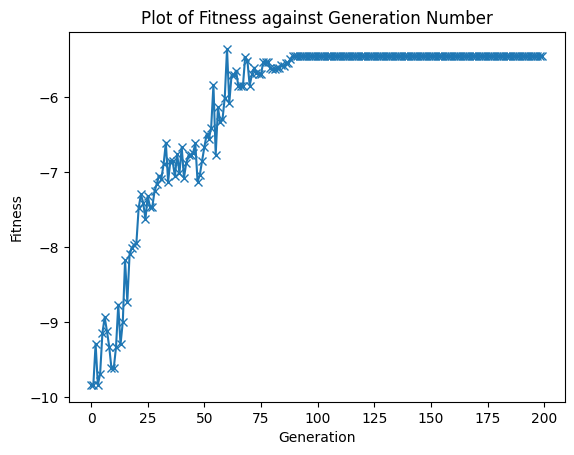

In [70]:
fig = EAP.printOptimumFitness()

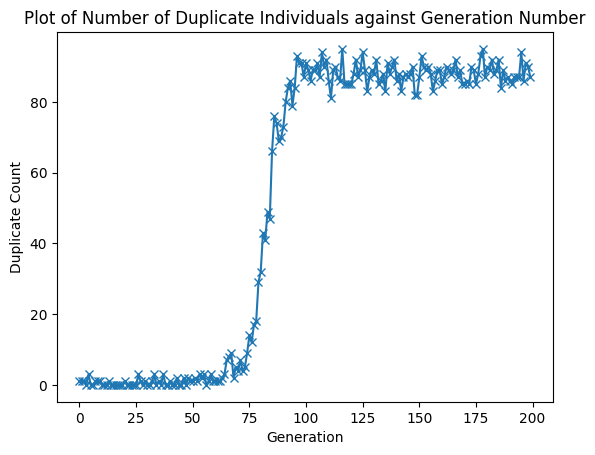

In [71]:
EAP.printDuplicateCount()

We can now introduce a version of $eaFSTSP\_One$ with elitism.

In [72]:
class eaFSTSP_One_elitism:
    def __init__(self, population_size, number_of_cities, distance_matrix, truck_distance_matrix, drone_distance_matrix):
        #number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability
        self.population_size = population_size
        self.number_of_cities = number_of_cities
        self.distance_matrix = distance_matrix
        self.truck_distance_matrix = truck_distance_matrix
        self.drone_distance_matrix = drone_distance_matrix
        self.fstsp = eaFSTSP(self.distance_matrix, self.truck_distance_matrix, self.drone_distance_matrix, self.population_size, self.number_of_cities)
        
    #Initialize and evaluate population
    def initialize(self, drone_endurance, inverse_truck_speed, inverse_drone_speed):
        self.routes, self.allocation, self.population, self.fitness = self.fstsp.random_initialization(drone_endurance, inverse_truck_speed, inverse_drone_speed)
        return(self.routes, self.allocation, self.population, self.fitness)
        
    #Run the loop  
    def mainLoop(self, number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability, total_generations):
        #We can record time it takes for the loop 
        init_time = time.time()  
        
        generation_number =0
        initial_population = self.population
        initial_allocation = self.allocation
        self.fitness_array = []
        self.duplicates = []
        elite_member_index = initial_population['Fitness'].idxmax()
        elite_member = initial_population.iloc[elite_member_index]
        elite_allocation = initial_allocation.iloc[elite_member_index]
        elite_fitness = elite_member['Fitness']
        while(generation_number<total_generations):
            #Select parents
            mating_pool, allocation_pool = self.fstsp.parent_selection_tournament(number_of_parents, self.routes, self.allocation,self.fitness,tournament_size, tournament_probability)
            #Recombination
            offspring_database, offspring_allocation_database = self.fstsp.order_one_crossover(mating_pool, allocation_pool, number_of_offspring)
            #Mutation
            mutated_offspring_df, mutated_allocation_arrays_df = self.fstsp.two_opt_swap(offspring_database, offspring_allocation_database, mutation_probability)
            #Evaluation
            offspring_with_fitness, offspring_allocation = self.fstsp.evaluation(mutated_offspring_df, mutated_allocation_arrays_df)
            offspring_with_fitness.columns = initial_population.columns
            offspring_allocation.columns = initial_allocation.columns
            #Replacement
            next_population, next_allocation = self.fstsp.replacement(self.population, offspring_with_fitness, initial_allocation, offspring_allocation)
            #
            if elite_fitness < next_population['Fitness'].max():
                next_population = next_population
            else:
                minimum_index = next_population['Fitness'].idxmin()
                next_population.loc[minimum_index] = elite_member
                next_allocation.loc[minimum_index] = elite_allocation
            #Preparing for next generation
            self.routes = next_population.drop(next_population.columns[-1], axis=1)
            self.allocation = next_allocation
            self.fitness = next_population.iloc[:, -1].values.tolist()
      
            fitness = next_population['Fitness'].max()
            self.fitness_array.append(fitness)
            
            #
            elite_member_index = next_population['Fitness'].idxmax()
            elite_member = next_population.loc[elite_member_index]
            elite_allocation = next_allocation.loc[elite_member_index]
            elite_fitness = elite_member['Fitness']
            
            #
            duplicates_count = next_population.duplicated().sum()
            self.duplicates.append(duplicates_count)
            
            generation_number = generation_number + 1
        
        #Recording the end time
        final_time = time.time()
        
        total_time = final_time - init_time
        
        return(next_population, next_allocation, self.fitness, self.fitness_array, total_time)
        
    def printOptimumFitness(self):
        plt.plot(self.fitness_array, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Plot of Fitness against Generation Number')
        plt.savefig('eaFSTSP_One_elitism_Fitness_Gen_plot.png')
        plt.show()
        
    def printDuplicateCount(self):
        plt.plot(self.duplicates, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Duplicate Count')
        plt.title('Plot of Number of Duplicate Individuals against Generation Number')
        plt.savefig('eaFSTSP_One_elitism_Duplicates_Gen_eaFSTSP_One_elitism.png')
        plt.show()

In [73]:
#Test
EAP = eaFSTSP_One_elitism(100, 25, distance_dataframe_test, test_truck_time_dataframe, test_drone_time_dataframe)


In [74]:
tmp1, tmp2, tmp3, tmp4 = EAP.initialize(1, 1, 1)

In [75]:
EAP.mainLoop(75, 100, 3, 0.90, 0.20, 100)


(      1   2   3   4   5   6   7   8   9  10  ...  17  18  19  20  21  22  23  \
 1    12  11  22   1  18  14  10   4  23   3  ...  25   2   7  15   5   9   6   
 2    14  10   4  23   3   1  15  16  24   7  ...  13   9  21   6   8  11  12   
 3     4  23   3  17  24   2  19  16   1  13  ...  21   6   8  11  12  22  18   
 4    18  14  10   4  23   3  17  19  16   7  ...  15   1   9   6   8  21  11   
 5    22  18  14  17  19  10   4  23   3  16  ...  15  20   5   9  21   6   8   
 ..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
 96   22  18  14  10   4  23   3  17   2  21  ...   5  15  24  20   6   8   1   
 97   24  15  19   7   2   1   4  18  10   9  ...  23   5  25  21  16  20  11   
 98   14  22   4   2   8  20  25  18  23   1  ...   5  15   9   6   7  21  10   
 99   22  18  14   3   6   8  10   4  23   1  ...  25   2   7  15   9  20  21   
 100   6   8  21  12  11  22  18  14  10   4  ...  13  24  25   2   7  15  20   
 
      24  25  Fitness  
 1

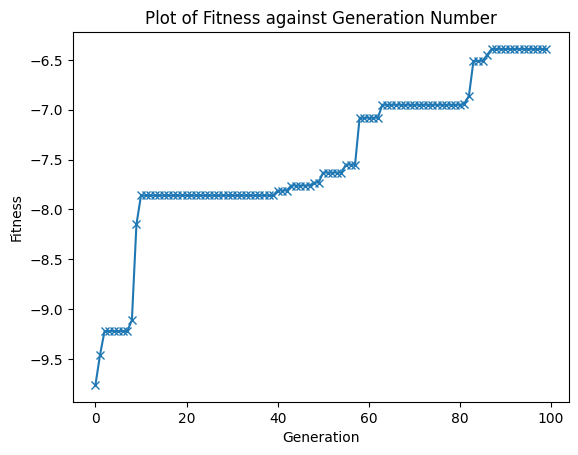

In [76]:
EAP.printOptimumFitness()

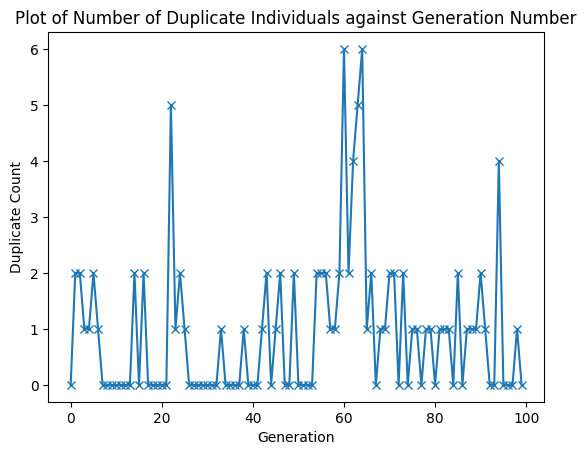

In [77]:
EAP.printDuplicateCount()

### The following code blocks have been changed to markdown to reduce loading time.

It is interesting to note that as population fitness increases the number of duplicates in the population also increase. It might be worth looking at whether a condition of the population being full of duplicates provides a more reasonable termination condition for a EA run.

class eaFSTSP_One_loop:
    def __init__(self, population_size, number_of_cities, distance_matrix, truck_distance_matrix, drone_distance_matrix):
        #number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability
        self.population_size = population_size
        self.number_of_cities = number_of_cities
        self.distance_matrix = distance_matrix
        self.truck_distance_matrix = truck_distance_matrix
        self.drone_distance_matrix = drone_distance_matrix
        self.fstsp = eaFSTSP(self.distance_matrix, self.truck_distance_matrix, self.drone_distance_matrix, self.population_size, self.number_of_cities)
        
    #Initialize and evaluate population
    def initialize(self, drone_endurance, inverse_truck_speed, inverse_drone_speed):
        self.routes, self.allocation, self.population, self.fitness = self.fstsp.random_initialization(drone_endurance, inverse_truck_speed, inverse_drone_speed)
        return(self.routes, self.allocation, self.population, self.fitness)
        
    #Run the loop  
    def mainLoop(self, number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability):
        #We can record time it takes for the loop 
        init_time = time.time()  
        
        generation_number =0
        initial_population = self.population
        initial_allocation = self.allocation
        self.fitness_array = []
        self.duplicates = []
        condition = False
        while(condition is False):
            #We can record time it takes for the loop 
            init_time = time.time()   
            #Select parents
            mating_pool, allocation_pool = self.fstsp.parent_selection_tournament(number_of_parents, self.routes, self.allocation,self.fitness,tournament_size, tournament_probability)
            #Recombination
            offspring_database, offspring_allocation_database = self.fstsp.order_one_crossover(mating_pool, allocation_pool, number_of_offspring)
            #Mutation
            mutated_offspring_df, mutated_allocation_arrays_df = self.fstsp.two_opt_swap(offspring_database, offspring_allocation_database, mutation_probability)
            #Evaluation
            offspring_with_fitness, offspring_allocation = self.fstsp.evaluation(mutated_offspring_df, mutated_allocation_arrays_df)
            offspring_with_fitness.columns = initial_population.columns
            offspring_allocation.columns = initial_allocation.columns
            #Replacement
            next_population, next_allocation = self.fstsp.replacement(self.population, offspring_with_fitness, initial_allocation, offspring_allocation)
            #Preparing for next generation
            self.routes = next_population.drop(next_population.columns[-1], axis=1)
            self.allocation = next_allocation
            self.fitness = next_population.iloc[:, -1].values.tolist()
      
            fitness = next_population['Fitness'].max()
            self.fitness_array.append(fitness)            
            
            duplicates_count = next_population.duplicated().sum()
            self.duplicates.append(duplicates_count)
            
            
            
            generation_number = generation_number + 1
            
            if (duplicates_count) > 0.90 * self.population_size:
                condition = True
            else:
                condition = False
            
        #Recording the end time
        final_time = time.time()
        
        total_time = final_time - init_time
        
        return(next_population, next_allocation, self.fitness, self.fitness_array, total_time)       
    
    def printOptimumFitness(self):
        plt.plot(self.fitness_array, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Plot of Fitness against Generation Number')
        plt.savefig('eaFSTSP_One_loop_Plot.png')
        plt.show()
        
    def printDuplicateCount(self):
        plt.plot(self.duplicates, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Duplicate Count')
        plt.title('Plot of Number of Duplicate Individuals against Generation Number')
        plt.savefig('eaFSTSP_One_loop_Duplicates_Gen_Plot.png')
        plt.show()

ea_l = eaFSTSP_One_loop(100, 25, distance_dataframe_test, test_truck_time_dataframe, test_drone_time_dataframe)

ea_l.initialize(1,1,1)

ea_l.mainLoop(75, 100, 3, 0.90, 0.10)

ea_l.printDuplicateCount()

ea_l.printOptimumFitness()

Let us try it with elitism.

class eaFSTSP_One_loop_elitisim:
    def __init__(self, population_size, number_of_cities, distance_matrix, truck_distance_matrix, drone_distance_matrix):
        #number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability
        self.population_size = population_size
        self.number_of_cities = number_of_cities
        self.distance_matrix = distance_matrix
        self.truck_distance_matrix = truck_distance_matrix
        self.drone_distance_matrix = drone_distance_matrix
        self.fstsp = eaFSTSP(self.distance_matrix, self.truck_distance_matrix, self.drone_distance_matrix, self.population_size, self.number_of_cities)
        
    #Initialize and evaluate population
    def initialize(self, drone_endurance, inverse_truck_speed, inverse_drone_speed):
        self.routes, self.allocation, self.population, self.fitness = self.fstsp.random_initialization(drone_endurance, inverse_truck_speed, inverse_drone_speed)
        return(self.routes, self.allocation, self.population, self.fitness)
        
    #Run the loop  
    def mainLoop(self, number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability):
         #We can record time it takes for the loop 
        init_time = time.time()  
        
        generation_number =0
        initial_population = self.population
        initial_allocation = self.allocation
        self.fitness_array = []
        self.duplicates = []
        elite_member_index = initial_population['Fitness'].idxmax()
        elite_member = initial_population.iloc[elite_member_index]
        elite_allocation = initial_allocation.iloc[elite_member_index]
        elite_fitness = elite_member['Fitness']
        condition = False
        while(condition is False):
            #Select parents
            mating_pool, allocation_pool = self.fstsp.parent_selection_tournament(number_of_parents, self.routes, self.allocation,self.fitness,tournament_size, tournament_probability)
            #Recombination
            offspring_database, offspring_allocation_database = self.fstsp.order_one_crossover(mating_pool, allocation_pool, number_of_offspring)
            #Mutation
            mutated_offspring_df, mutated_allocation_arrays_df = self.fstsp.two_opt_swap(offspring_database, offspring_allocation_database, mutation_probability)
            #Evaluation
            offspring_with_fitness, offspring_allocation = self.fstsp.evaluation(mutated_offspring_df, mutated_allocation_arrays_df)
            offspring_with_fitness.columns = initial_population.columns
            offspring_allocation.columns = initial_allocation.columns
            #Replacement
            next_population, next_allocation = self.fstsp.replacement(self.population, offspring_with_fitness, initial_allocation, offspring_allocation)
                        #
            if elite_fitness < next_population['Fitness'].max():
                next_population = next_population
            else:
                minimum_index = next_population['Fitness'].idxmin()
                next_population.loc[minimum_index] = elite_member
                next_allocation.loc[minimum_index] = elite_allocation
                
            #Preparing for next generation
            self.routes = next_population.drop(next_population.columns[-1], axis=1)
            self.allocation = next_allocation
            self.fitness = next_population.iloc[:, -1].values.tolist()
      
            fitness = next_population['Fitness'].max()
            self.fitness_array.append(fitness)           
            
            elite_member_index = next_population['Fitness'].idxmax()
            elite_member = next_population.loc[elite_member_index]
            elite_allocation = next_allocation.loc[elite_member_index]
            elite_fitness = elite_member['Fitness'] 
            
            duplicates_count = next_population.duplicated().sum()
            self.duplicates.append(duplicates_count)
            
            
            generation_number = generation_number + 1
            
            if (duplicates_count) > 0.90 * self.population_size:
                condition = True
            else:
                condition = False
            
        #Recording the end time
        final_time = time.time()
        
        total_time = final_time - init_time
        
        return(next_population, next_allocation, self.fitness, self.fitness_array, total_time)
    
    def printOptimumFitness(self):
        plt.plot(self.fitness_array, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Plot of Fitness against Generation Number')
        plt.savefig('Fitness_Gen_eaFSTSP_One_loop_elitism.png')
        plt.show()
        
    def printDuplicateCount(self):
        plt.plot(self.duplicates, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Duplicate Count')
        plt.title('Plot of Number of Duplicate Individuals against Generation Number')
        plt.savefig('Duplicate_Gen_eaFSTSP_One_loop_elitism.png')
        plt.show()

ea_l = eaFSTSP_One_loop_elitisim(100, 25, distance_dataframe_test, test_truck_time_dataframe, test_drone_time_dataframe)

ea_l.initialize(1,1,1)

ea_l.mainLoop(75, 100, 3, 0.90, 0.10)

ea_l.printOptimumFitness()

ea_l.printDuplicateCount()

The class $eaFSTSP\_Two$ runs the EA on the following test case: 
- Initialisation: heuristic initialization
- Parent Selection: parent_selection_tournament
- Recombination: order_one_crossover
- Mutation: two_opt_swap
- Replacement: generational
- Elitisim: False

class eaFSTSP_Two:
    def __init__(self, population_size, number_of_cities, distance_matrix, truck_distance_matrix, drone_distance_matrix):
        #number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability
        self.population_size = population_size
        self.number_of_cities = number_of_cities
        self.distance_matrix = distance_matrix
        self.truck_distance_matrix = truck_distance_matrix
        self.drone_distance_matrix = drone_distance_matrix
        self.fstsp = eaFSTSP(self.distance_matrix, self.truck_distance_matrix, self.drone_distance_matrix, self.population_size, self.number_of_cities)
        
    #Initialize and evaluate population
    def initialize(self, drone_endurance, inverse_truck_speed, inverse_drone_speed):
        self.routes, self.allocation, self.population, self.fitness = self.fstsp.heuristic_initialization(drone_endurance, inverse_truck_speed, inverse_drone_speed)
        return(self.routes, self.allocation, self.population, self.fitness)
        
    #Run the loop  
    def mainLoop(self, number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability, total_generations):
         #We can record time it takes for the loop 
        init_time = time.time() 
        
        generation_number =0
        initial_population = self.population
        initial_allocation = self.allocation
        self.fitness_array = []
        self.duplicates = []
        while(generation_number<total_generations):
            #Select parents
            mating_pool, allocation_pool = self.fstsp.parent_selection_tournament(number_of_parents, self.routes, self.allocation,self.fitness,tournament_size, tournament_probability)
            #Recombination
            offspring_database, offspring_allocation_database = self.fstsp.order_one_crossover(mating_pool, allocation_pool, number_of_offspring)
            #Mutation
            mutated_offspring_df, mutated_allocation_arrays_df = self.fstsp.two_opt_swap(offspring_database, offspring_allocation_database, mutation_probability)
            #Evaluation
            offspring_with_fitness, offspring_allocation = self.fstsp.evaluation(mutated_offspring_df, mutated_allocation_arrays_df)
            offspring_with_fitness.columns = initial_population.columns
            offspring_allocation.columns = initial_allocation.columns
            #Replacement
            next_population, next_allocation = self.fstsp.replacement(self.population, offspring_with_fitness, initial_allocation, offspring_allocation)
            #Preparing for next generation
            self.routes = next_population.drop(next_population.columns[-1], axis=1)
            self.allocation = next_allocation
            self.fitness = next_population.iloc[:, -1].values.tolist()
      
            fitness = next_population['Fitness'].max()
            self.fitness_array.append(fitness)
            
            duplicates_count = next_population.duplicated().sum()
            self.duplicates.append(duplicates_count)
            
            generation_number = generation_number + 1
            
        #Recording the end time
        final_time = time.time()
        
        total_time = final_time - init_time
        
        return(next_population, next_allocation, self.fitness, self.fitness_array, total_time)
        
    def printOptimumFitness(self):
        plt.plot(self.fitness_array, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Plot of Fitness against Generation Number')
        plt.savefig('eaFSTSP_Two_Fitness_Gen_Plot.png')
        plt.show()
        
    def printDuplicateCount(self):
        plt.plot(self.duplicates, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Duplicate Count')
        plt.title('Plot of Number of Duplicate Individuals against Generation Number')
        plt.savefig('eaFSTSP_Two_Duplicates_Gen_Plot.png')

        plt.show()

ea = eaFSTSP_Two(100, 25, distance_dataframe_test, test_truck_time_dataframe, test_drone_time_dataframe)

ea.initialize(1, 1, 1)

ea.mainLoop(75, 100, 2, 0.9, 0.10, 200)

ea.printOptimumFitness()

ea.printDuplicateCount()

The class $eaFSTSP\_Two\_elitism$ runs the EA on the following test case: 
- Initialisation: heuristic initialization
- Parent Selection: parent_selection_tournament
- Recombination: order_one_crossover
- Mutation: two_opt_swap
- Replacement: generational
- Elitisim: True

class eaFSTSP_Two_elitism:
    def __init__(self, population_size, number_of_cities, distance_matrix, truck_distance_matrix, drone_distance_matrix):
        #number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability
        self.population_size = population_size
        self.number_of_cities = number_of_cities
        self.distance_matrix = distance_matrix
        self.truck_distance_matrix = truck_distance_matrix
        self.drone_distance_matrix = drone_distance_matrix
        self.fstsp = eaFSTSP(self.distance_matrix, self.truck_distance_matrix, self.drone_distance_matrix, self.population_size, self.number_of_cities)
        
    #Initialize and evaluate population
    def initialize(self, drone_endurance, inverse_truck_speed, inverse_drone_speed):
        self.routes, self.allocation, self.population, self.fitness = self.fstsp.heuristic_initialization(drone_endurance, inverse_truck_speed, inverse_drone_speed)
        return(self.routes, self.allocation, self.population, self.fitness)
        
    #Run the loop  
    def mainLoop(self, number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability, total_generations):
        #We can record time it takes for the loop 
        init_time = time.time() 
        
        generation_number =0
        initial_population = self.population
        initial_allocation = self.allocation
        self.fitness_array = []
        self.duplicates = []
        elite_member_index = initial_population['Fitness'].idxmax()
        elite_member = initial_population.iloc[elite_member_index]
        elite_allocation = initial_allocation.iloc[elite_member_index]
        elite_fitness = elite_member['Fitness']
        while(generation_number<total_generations):
            #Select parents
            mating_pool, allocation_pool = self.fstsp.parent_selection_tournament(number_of_parents, self.routes, self.allocation,self.fitness,tournament_size, tournament_probability)
            #Recombination
            offspring_database, offspring_allocation_database = self.fstsp.order_one_crossover(mating_pool, allocation_pool, number_of_offspring)
            #Mutation
            mutated_offspring_df, mutated_allocation_arrays_df = self.fstsp.two_opt_swap(offspring_database, offspring_allocation_database, mutation_probability)
            #Evaluation
            offspring_with_fitness, offspring_allocation = self.fstsp.evaluation(mutated_offspring_df, mutated_allocation_arrays_df)
            offspring_with_fitness.columns = initial_population.columns
            offspring_allocation.columns = initial_allocation.columns
            #Replacement
            next_population, next_allocation = self.fstsp.replacement(self.population, offspring_with_fitness, initial_allocation, offspring_allocation)
            #
            if elite_fitness < next_population['Fitness'].max():
                next_population = next_population
            else:
                minimum_index = next_population['Fitness'].idxmin()
                next_population.loc[minimum_index] = elite_member
                next_allocation.loc[minimum_index] = elite_allocation
            #Preparing for next generation
            self.routes = next_population.drop(next_population.columns[-1], axis=1)
            self.allocation = next_allocation
            self.fitness = next_population.iloc[:, -1].values.tolist()
      
            fitness = next_population['Fitness'].max()
            self.fitness_array.append(fitness)
            
            #
            elite_member_index = next_population['Fitness'].idxmax()
            elite_member = next_population.loc[elite_member_index]
            elite_allocation = next_allocation.loc[elite_member_index]
            elite_fitness = elite_member['Fitness']
            
            #
            duplicates_count = next_population.duplicated().sum()
            self.duplicates.append(duplicates_count)
            
            generation_number = generation_number + 1
        
        #Recording the end time
        final_time = time.time()
        
        total_time = final_time - init_time
        
        return(next_population, next_allocation, self.fitness, self.fitness_array, total_time)
        
    def printOptimumFitness(self):
        plt.plot(self.fitness_array, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Plot of Fitness against Generation Number')
        plt.savefig('eaFSTSP_Two_elitism_Fitness_Gen_Plot.png')
        plt.show()
        
    def printDuplicateCount(self):
        plt.plot(self.duplicates, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Duplicate Count')
        plt.title('Plot of Number of Duplicate Individuals against Generation Number')
        plt.savefig('eaFSTSP_Two_elitism_Duplicates_Gen_Plot.png')
        plt.show()

ea = eaFSTSP_Two_elitism(100, 25, distance_dataframe_test, test_truck_time_dataframe, test_drone_time_dataframe)

ea.initialize(1,1,1)

ea.mainLoop(75, 100, 2, 0.9, 0.1, 200)

ea.printOptimumFitness()

ea.printDuplicateCount()

# Testing

We can use the databases generated in the second algorithm for testing, i.e. tmp1, tmp2, tmp3 and tmp4.

#Let us test the recombination operator OX1
parent_one = tmp3.iloc[2]
parent_two = tmp3.iloc[3]

allocation_one = tmp2.iloc[2]
allocation_two = tmp2.iloc[3]

#Let us print the arrays
print(np.array(parent_one))
print(np.array(parent_two))
print(np.array(allocation_one))
print(np.array(allocation_two))

I am going to modify the code slightly so that it returns the cut off points.

def FSTSP_OX1Crossover_testing(parent_one, parent_two, allocation_one, allocation_two):
    #Creating the offspring, and obtaining the cut-off points to use with the allocation arrays
    offspring, ordered_indices = OX1Crossover_special(parent_one, parent_two)
    
    #Determining cuttoffpoints
    cutoff_point_one = ordered_indices[0]
    cutoff_point_two = ordered_indices[1]
    offspring_allocation = np.array([0]*(len(allocation_one)))
    
    #Obtaining the corresponding allocation values for the nodes copied from parent one
    allocation_values_one = allocation_one[cutoff_point_one: cutoff_point_two]
    offspring_allocation[cutoff_point_one:cutoff_point_two] = allocation_values_one
    
    #Obtaining the remaining allocation values from parent two
    allocation_values_two = allocation_two[cutoff_point_two:]
    offspring_allocation[cutoff_point_two:] = allocation_values_two
    
    #Obtaining the allocaiton values from the beginning of parent two
    allocation_values_three = allocation_two[:cutoff_point_one]
    offspring_allocation[:cutoff_point_one] = allocation_values_three
    
    #
    #offspring_allocation = ensure_validity_of_allocation_simple(offspring_allocation)
    
    return(offspring,offspring_allocation, ordered_indices)
    

print(np.array(parent_one))
print(np.array(parent_two))
print(np.array(allocation_one))
print(np.array(allocation_two))
FSTSP_OX1Crossover_testing(parent_one, parent_two, allocation_one, allocation_two)

Let us now test $FSTSP\_OX1Crossover\_R$.

def FSTSP_OX1Crossover_R_testing(parent_one, parent_two, allocation_one, allocation_two):
    offspring = OX1Crossover(parent_one, parent_two)
    offspring_allocation = np.array([0]*(len(allocation_one)))
    
    #We can perform the crossover algorithm on the allocation arrays
    
    #Choosing the indices for the cut-off points in both arrays
    #Create a random number generator using the numpy.random module
    rng = npr.default_rng()
    cutoff_point_one, cutoff_point_two = rng.choice(len(allocation_one), 2, replace = False)
    #Ordering the parent indices 
    ordered_indices = np.sort([cutoff_point_one, cutoff_point_two])
    cutoff_point_one, cutoff_point_two = ordered_indices[0], ordered_indices[1]
    
    #Obtaining the corresponding allocation values for the nodes copied from parent one
    allocation_values_one = allocation_one[cutoff_point_one: cutoff_point_two]
    offspring_allocation[cutoff_point_one:cutoff_point_two] = allocation_values_one
    
    #Obtaining the remaining allocation values from parent two
    allocation_values_two = allocation_two[cutoff_point_two:]
    offspring_allocation[cutoff_point_two:] = allocation_values_two
    
    #Obtaining the allocaiton values from the beginning of parent two
    allocation_values_three = allocation_two[:cutoff_point_one]
    offspring_allocation[:cutoff_point_one] = allocation_values_three
    
    #
    #offspring_allocation = ensure_validity_of_route_simple(offspring_allocation)
    #offspring_allocation = ensure_validity_of_allocation(offspring_allocation, offspring, drone_endurance, distance_dataframe)
    
    return(offspring, offspring_allocation, ordered_indices)

print(np.array(allocation_one))
print(np.array(allocation_two))
FSTSP_OX1Crossover_R_testing(parent_one, parent_two, allocation_one, allocation_two)


Let us now test $FSTSP\_OX1Crossover\_C$.

FSTSP_OX1Crossover_C(parent_one, parent_two, allocation_one, allocation_two)

Let us test the $FSTSP\_TwoOptFlip$ operator.

parent_one = np.array(parent_one)
allocation_one = np.array(allocation_one)

FSTSP_TwoOptFlip(parent_one, allocation_one)